<a href="https://colab.research.google.com/github/blue-create/langlens/blob/main/analyses/analyse_labels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Reviewing Label Categories
1. exporting annotations from Elinor
2. grouping into "Domestic Violence" vs. not "Domestic Violence"
  - vizualizing categories
  - export paragraphs for manual review
3. Focus on the Domestic Violence Articles
  - vizualize
  - export for manual review
4. Focus on 3 relevant label categories
  - vizualize
  - export for manual review


### Imports

In [1]:
%%capture
!pip install transformers==4.20.0

In [2]:
# PACKAGES
import pandas as pd
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import plotly.express as px
from transformers import AutoTokenizer
from sklearn.manifold import TSNE


In [3]:
# connect with google drive
from google.colab import drive
drive.mount('/content/drive')
# change cwd
%cd drive/MyDrive/Work/Frontline/data/


Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1WfnZsqpG1r110J63sMbfS5TpsDOkveiV/data


In [4]:
# CUSTOM PACKAGES
from scripts import annotations

### 1.Exporting annotations from Elinor

In [5]:
# list of dfs with all annotated datasets
dfs={}
for doc in os.listdir("annotated/new_ontology"):
  if doc.endswith(".json"):
    #read json data
    json_data=json.load(open("annotated/new_ontology/"+doc, encoding="utf-8"))
    #convert to dataframe
    data=pd.DataFrame(json_data["documents"])
    data.loc[:,"file"]=doc
    dfs[doc]=data

data=pd.concat(dfs,ignore_index=True)

Extract:artikel_id, titel, annotations


In [6]:
data.loc[:,"artikel_id"]=data.attributes_flat.apply(lambda x: x["artikel_id"])
data.loc[:,"titel"]=data.attributes_flat.apply(lambda x: x["titel"])
data.loc[:,"annotations"]=data.loc[:,"annotations"].apply(annotations.extract_annotations)


In [7]:
print("Number of total annotated articles:",data.shape[0])


Number of total annotated articles: 3000


### 2."Domestic Violence" vs. not "Domestic Violence"

Binary Label: Other/ Domestic Violence

In [8]:
data.loc[:,"label"]=data.annotations.apply(lambda x: "Other" if x=={} else "Domestic Violence")

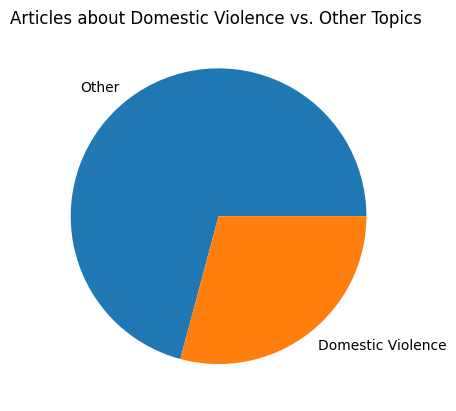

In [9]:
plt.pie(data.label.value_counts(),labels=data.label.value_counts().index);
plt.title("Articles about Domestic Violence vs. Other Topics ");

In [10]:
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

Downloading:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/953 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

#### [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) Plots

In [11]:
tokens=data.text.apply(lambda x: tokenizer(x,padding="max_length")["input_ids"])

2D Modelling

In [12]:
tsne_res=TSNE(n_components=2, metric="cosine").fit_transform(tokens.apply(pd.Series).to_numpy(),)

In [13]:
lst1, lst2 = zip(*tsne_res)

In [14]:
col=["red" if x=="Other" else "blue" for x in data.label ]

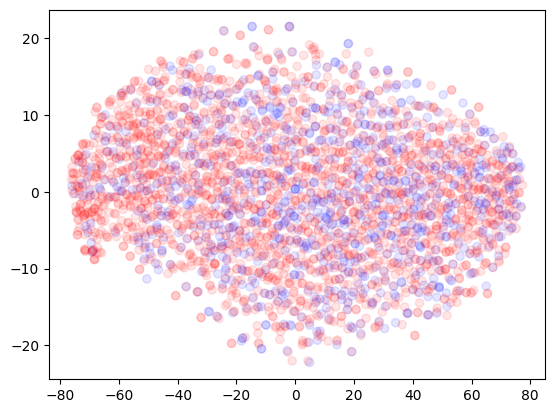

In [15]:
plt.scatter(lst1, lst2,c=col,alpha=0.1,label=["Other","Domestic Violence"]);

3D Modelling

In [16]:
tsne_res=TSNE(n_components=3, metric="cosine").fit_transform(tokens.apply(pd.Series).to_numpy())

In [17]:
data.label.value_counts()

Other                2125
Domestic Violence     875
Name: label, dtype: int64

In [18]:
fig = px.scatter_3d(pd.DataFrame(tsne_res), x=0, y=1, z=2,color=list(data.label),opacity=0.3)
fig.show()

#### Export Sample for manual Check

In [19]:
#data.sample(500).to_csv("sample_all_manual_check.csv", index=False)

### 3.Focus on the Domestic Violence Articles

In [75]:
data_dv=data[data.annotations.apply(len)!=0]

In [76]:
data_dv.loc[:,"label"]=data_dv.annotations.apply(lambda x: list(x["K"]))

<ipython-input-76-0ccaea32be61>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [77]:
tokens=data_dv.text.apply(lambda x: tokenizer(x,padding="max_length")["input_ids"])

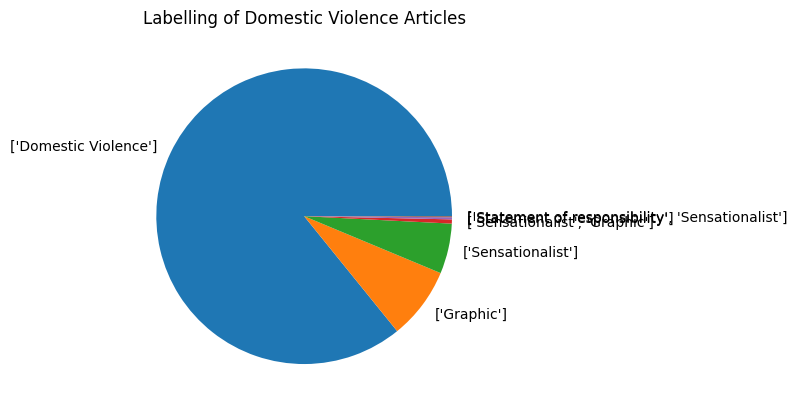

In [78]:
plt.pie(data_dv.label.value_counts(),labels=data_dv.label.value_counts().index);
plt.title("Labelling of Domestic Violence Articles");

2D Modelling

In [79]:
tsne_res=TSNE(n_components=2, metric="cosine").fit_transform(tokens.apply(pd.Series).to_numpy(),)

In [80]:
lst1, lst2 = zip(*tsne_res)

In [81]:
def color(term):
  match sorted(term):
    case ["Domestic Violence"]:
         return "grey"
    case ["Graphic"]:
        return "blue"
    case ["Sensationalist"]:
        return "red"
    case ["Statement of responsibility"]:
        return "yellow"
    case ["Graphic", "Sensationalist"]:
        return "purple"
    case ["Sensationalist", "Statement of responsibility"]:
        return "orange"

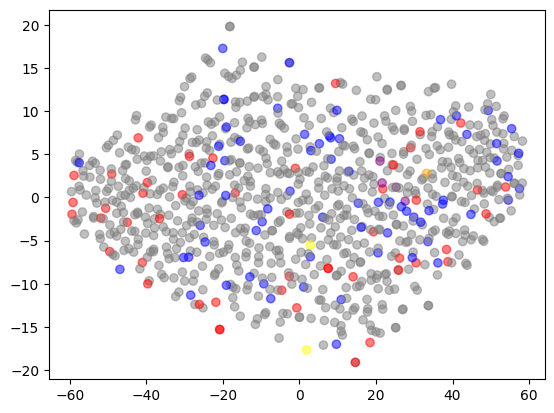

In [82]:
plt.scatter(lst1, lst2,alpha=0.5, c=col);

3D Modelling

In [83]:
tsne_res=TSNE(n_components=3, metric="cosine").fit_transform(tokens.apply(pd.Series).to_numpy())

In [84]:
lab=data_dv.label.astype(str)

In [85]:
fig = px.scatter_3d(pd.DataFrame(tsne_res), x=0, y=1, z=2,color=list(lab),opacity=0.3)
fig.show()

### 4.Focus on 3 relevant label categories

In [86]:
data_rel=data_dv[lab!="['Domestic Violence']"]
data_rel.shape

(124, 8)

In [87]:
tokens=data_rel.text.apply(lambda x: tokenizer(x,padding="max_length")["input_ids"])

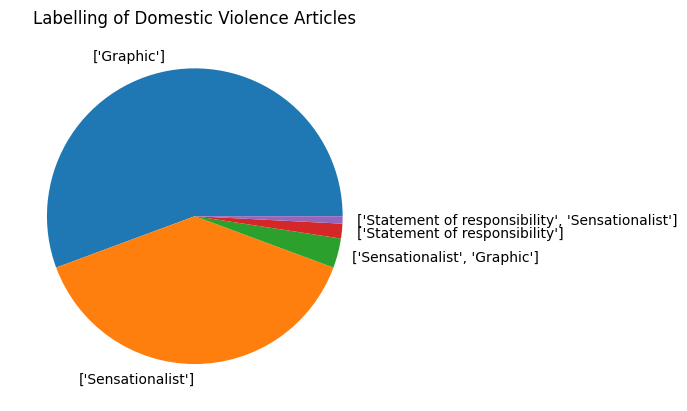

In [88]:
plt.pie(data_rel.label.value_counts(),labels=data_rel.label.value_counts().index);
plt.title("Labelling of Domestic Violence Articles");

2D Modelling

In [89]:
tsne_res=TSNE(n_components=2, metric="cosine").fit_transform(tokens.apply(pd.Series).to_numpy(),)

In [90]:
lst1, lst2 = zip(*tsne_res)

In [91]:
col=data_rel.label.apply(color)

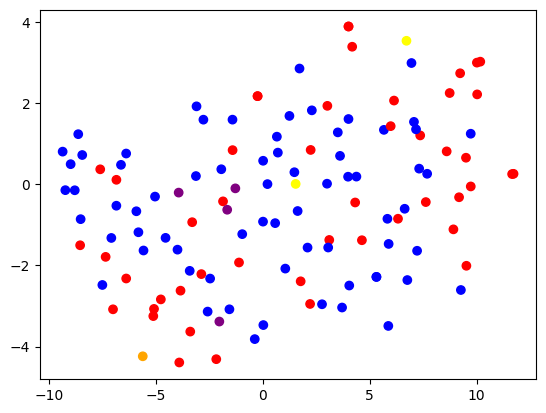

In [92]:
plt.scatter(lst1, lst2,c=col.values);